# Chapter 5: The Many Variables & The Spurious Waffles - Samples

In [1]:
import pathlib
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from matplotlib import pyplot as plt
from scipy import stats
import daft
from causalgraphicalmodels import CausalGraphicalModel

### Code 5.1

**Spurious Association**

In [2]:
DATA_PATH = pathlib.Path('..') / '..' / 'data'

def standardize(data: np.ndarray):
    return (data - data.mean()) / data.std()

d = pd.read_csv(DATA_PATH.joinpath('WaffleDivorce.csv'), sep=';')
d['A'] = standardize(d['MedianAgeMarriage'])
d['D'] = standardize(d['Divorce'])
d['M'] = standardize(d['Marriage'])

### Code 5.2

We can do linear regression with `MedianAgeMarriage` as a predictor. The model could be:

$$D_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_AA_i$$
$$\alpha \sim \text{Normal}(0, 0.2)$$
$$\beta_A \sim \text{Normal}(0, 0.5)$$
$$\sigma \sim \text{Exponential}(1)$$

To understand what does the prior $\beta_A$ imply, if it is equal to 1, it would change one standard deviation.

In [3]:
d['MedianAgeMarriage'].std()

1.2436303013880823

### Code 5.3

Computing the approximate posterior.

In [43]:
with pm.Model() as m5_1:
    sigma = pm.Exponential('sigma', 1)
    bA = pm.Normal('bA', mu=0, sigma=0.5)
    a = pm.Normal('a', mu=0, sigma=0.2)
    mu = pm.Deterministic('mu', a + bA*d['A'].values)
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=d['D'].values)
    prior_samples = pm.sample_prior_predictive(return_inferencedata=False, samples=50)
    trace5_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


### Code 5.4

Plotting the different lines.

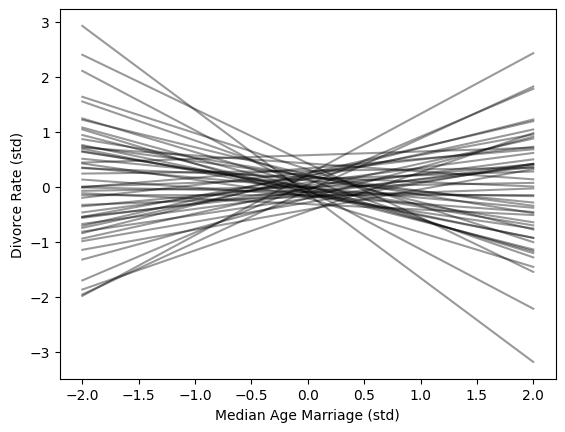

In [5]:
x_s = np.linspace(-2, 2, 50)
alpha_s = prior_samples['a']
bA_s = prior_samples['bA']

data = alpha_s[:,  np.newaxis] + (bA_s[:, np.newaxis] * np.tile(x_s, (50, 1)))

for line in data:
    plt.plot(x_s, line, 'black', alpha=0.4)
    
plt.xlabel("Median Age Marriage (std)")
plt.ylabel("Divorce Rate (std)");

### Code 5.5

Now compute the posterior predictions.

In [6]:
# compute percentile interval of mean
mean_q = pm.find_MAP(model=m5_1)
H = pm.find_hessian(mean_q, model=m5_1)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, bA, sigma]])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

In [8]:
A_seq = np.linspace(-3, 3.2, 30)
post = posterior.rvs(10_000)

mu = post[:, 0:1] + (post[:, 1:2] * np.tile(A_seq, (10_000, 1)))
sigmas = np.tile(post[:, 2], (30, 1)).T
posterior_sample = np.random.normal(loc=mu, scale=sigmas, size=(10_000, 30))

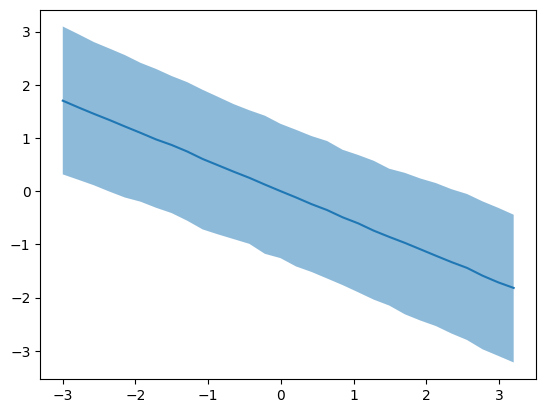

In [10]:
post_mean = posterior_sample.mean(axis=0)
post_pi = np.array([np.quantile(m, [0.055, 0.945]) for m in posterior_sample.T])
plt.plot(A_seq, post_mean);
plt.fill_between(A_seq, post_pi[:, 0], post_pi[:, 1], alpha=0.5);

### Code 5.6

You can fit the Marriage Rate as well.

In [48]:
with pm.Model() as m5_2:
    sigma = pm.Exponential('sigma', 1)
    bM = pm.Normal('bM', mu=0, sigma=0.5)
    a = pm.Normal('a', mu=0, sigma=0.2)
    mu = pm.Deterministic('mu', a + bM*d['M'].values)
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=d['D'].values)
    trace5_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


### Code 5.7

Drawing a DAG

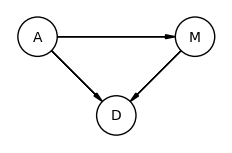

In [35]:
dag5_1 = CausalGraphicalModel(nodes=['A', 'D', 'M'], edges=[('A', 'D'), ('A', 'M'), ('M', 'D')])
pgm = daft.PGM()
coordinates = {'A': (0, 0), 'D': (1, 1), 'M': (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis();

### Code 5.8

Define the second DAG and display the implied conditional independencies.

[('M', 'D', {'A'})]


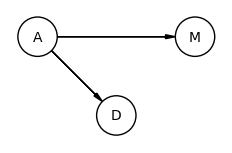

In [36]:
dag5_2 = CausalGraphicalModel(nodes=['A', 'D', 'M'], edges=[('A', 'D'), ('A', 'M')])
pgm = daft.PGM()
coordinates = {'A': (0, 0), 'D': (1, 1), 'M': (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis();

print(dag5_2.get_all_independence_relationships())

### Code 5.9

The first DAG has no conditional independencies, you can define it and check.

In [37]:
print(dag5_1.get_all_independence_relationships())

[]


### Code 5.10

To see the differences when we add another variable, we can fit to both.

In [41]:
with pm.Model() as m5_3:
    a = pm.Normal('a', 0, 0.2)
    bA = pm.Normal('bA', 0, 0.5)
    bM = pm.Normal('bM', 0, 0.5)

    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + bM * d['M'].values + bA * d['A'].values)

    div = pm.Normal(
        'div', mu=mu, sigma=sigma, observed=d['D'].values
    )
    trace5_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


### Code 5.11

Plot the coefficients

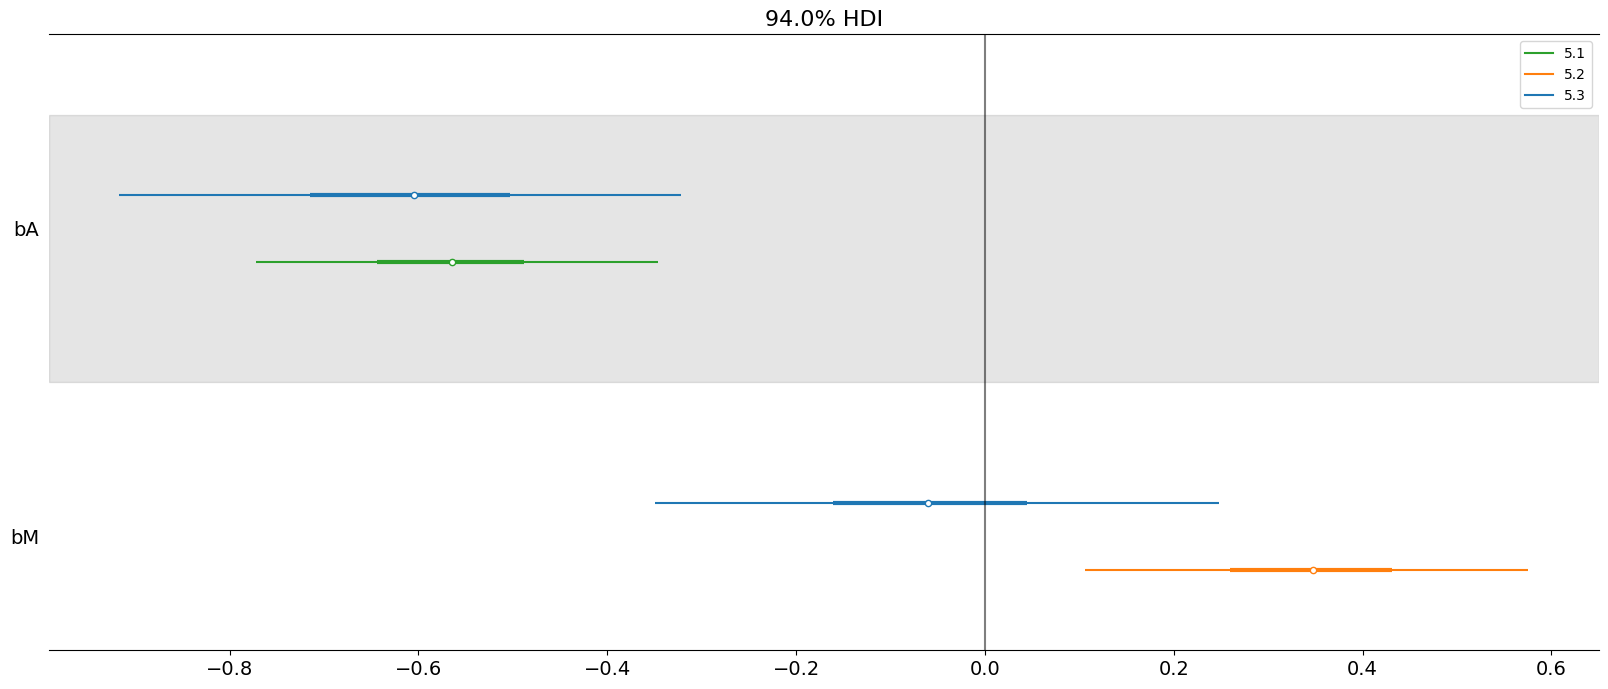

In [63]:
az.plot_forest(
    [trace5_3, trace5_2, trace5_1],
    model_names=['5.3', '5.2', '5.1'],
    var_names=['bA', 'bM'],
    combined=True, figsize=(20,8));
plt.axvline(0, color='black', alpha=0.5);